In [43]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import *
from sklearn.model_selection import KFold
from sklearn.metrics import  make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
import seaborn as sns

import matplotlib.pyplot as plt
import joblib
from joblib import dump, load

In [8]:
df_data = pd.read_csv("classification_inference.csv", sep=";")
columns = ["survival_class", "surgery_class", "oms", "prob_class_0", "prob_class_1", "prob_class_2"]
df_data = df_data[columns]
df_data.dropna(axis=0)

,survival_class,surgery_class,oms,prob_class_0,prob_class_1,prob_class_2
0,2,2,1.0,0.192732,0.093418,0.713850
1,2,2,1.0,0.216373,0.098615,0.685012
2,2,2,1.0,0.429667,0.031869,0.538464
3,2,2,1.0,0.316145,0.006877,0.676978
4,2,2,1.0,0.380610,0.011954,0.607435
...,...,...,...,...,...,...
319,1,1,2.0,0.236630,0.624722,0.138648
320,1,1,2.0,0.080246,0.846476,0.073278
321,1,1,2.0,0.136776,0.734428,0.128796
322,1,1,2.0,0.170933,0.692235,0.136832


In [12]:
#Répartition des données:

X = df_data.drop("survival_class", axis =1)
y = df_data["survival_class"]

In [17]:
X_np = np.array(X)
sc = StandardScaler()
X_norm = sc.fit_transform(X_np)
X = X_norm

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)

C:\Users\M105411\AppData\Local\Temp\ipykernel_36920\2762655003.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x=df_graph.index, y=df_graph["Score entrainement"].values, data=df_graph, ax=axs[0], palette = custom_palette)
C:\Users\M105411\AppData\Local\Temp\ipykernel_36920\2762655003.py:35: UserWarning: The palette list has more values (11) than needed (9), which may not be intended.
  ax1 = sns.barplot(x=df_graph.index, y=df_graph["Score entrainement"].values, data=df_graph, ax=axs[0], palette = custom_palette)
C:\Users\M105411\AppData\Local\Temp\ipykernel_36920\2762655003.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x=df_graph.index, y=df_graph["Score de prédicti

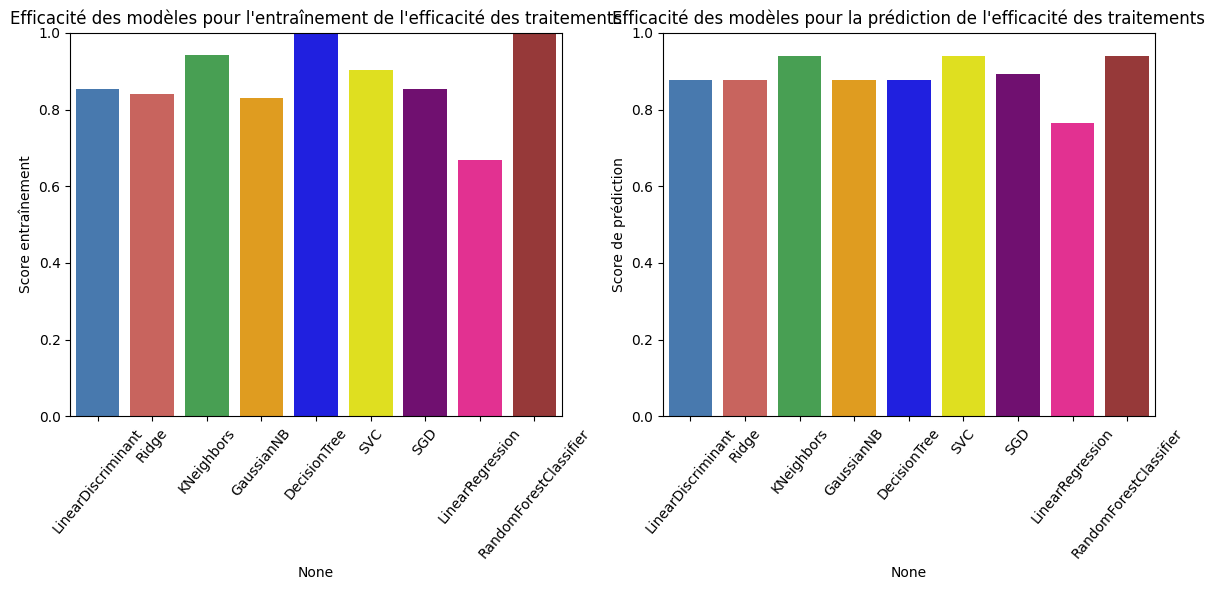

In [121]:
# Création des modèles
List_of_models = [LinearDiscriminantAnalysis(), RidgeClassifier(), KNeighborsClassifier(), GaussianNB(), DecisionTreeClassifier(), SVC(), SGDClassifier(), LinearRegression(), RandomForestClassifier()]
List_of_models_for_graph = ["LinearDiscriminant", "Ridge", "KNeighbors", "GaussianNB", "DecisionTree", "SVC", "SGD", "LinearRegression", "RandomForestClassifier"]

def run_model_and_performance_check(model):

    # Choix du modèle et entraînement du modèle
    model_class = model
    model_class.fit(X_train, y_train)

    # Prédiction du modèle et archivage des résultats
    y_pred = model_class.predict(X_test)

    # Création des dataframes résultats
    results_classification = np.array([model_class.score(X_train,y_train), model_class.score(X_test,y_test)])
    df_results = pad.DataFrame(index = ["Score entrainement", "Score de prédiction"], columns = [str(model)[:-2]])
    df_results[str(model)[:-2]] = results_classification

    return df_results

df_results = pd.DataFrame(index = ["Score entrainement", "Score de prédiction", "MAE", "RMSE", "median absolute error"], columns = ["LinearDiscriminant"])

for i in range(len(List_of_models)):
  model_class = List_of_models[i] 
  model_class.fit(X_train, y_train)
  y_pred = model_class.predict(X_test)
  results_classification = np.array([model_class.score(X_train,y_train), model_class.score(X_test,y_test), mean_absolute_error(y_test,y_pred), np.sqrt(mean_squared_error(y_test,y_pred)), median_absolute_error(y_test,y_pred)])
  df_results[List_of_models_for_graph[i]] = results_classification

custom_palette = [sns.xkcd_rgb["windows blue"], sns.xkcd_rgb["pale red"], sns.xkcd_rgb["medium green"], "orange", "blue","yellow", "purple", "deeppink", "brown", "teal", "black"] 
sns.set_palette(custom_palette)

df_graph = df_results.transpose()
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
ax1 = sns.barplot(x=df_graph.index, y=df_graph["Score entrainement"].values, data=df_graph, ax=axs[0], palette = custom_palette)
ax2 = sns.barplot(x=df_graph.index, y=df_graph["Score de prédiction"].values, data=df_graph, ax=axs[1], palette = custom_palette)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=50)
ax1.set_title('Efficacité des modèles pour l\'entraînement de l\'efficacité des traitements')
ax1.set_ylabel('Score entraînement')
ax1.set(ylim=(0, 1))
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=50)
ax2.set_title('Efficacité des modèles pour la prédiction de l\'efficacité des traitements')
ax2.set_ylabel('Score de prédiction')
ax2.set(ylim=(0, 1))

plt.tight_layout()

In [122]:
# Modèle LinearDiscriminant 
LinearDiscriminant_parameters = {'solver' : ['svd', 'lsqr', 'eigen'], 
                                 'store_covariance' : [True, False],
                                 'tol' : [0.0001,0.0002,0.0003]}

LinearDiscriminant_GridSearchCV = GridSearchCV(estimator = LinearDiscriminantAnalysis(), param_grid = LinearDiscriminant_parameters, cv = 5, n_jobs=-1)
LinearDiscriminant_GridSearchCV.fit(X_train, y_train)
LinearDiscriminant_GridSearchCV.best_params_
print("LinearDiscriminant best param = " + str(LinearDiscriminant_GridSearchCV.best_params_))

# Modèle RidgeClassifier
RidgeClassifier_parameters = {'alpha' : list(range(1,20)),
                              'fit_intercept' : [True, False],
                              'copy_X' : [True, False],
                              'tol' : [0.0001,0.0002,0.0003],
                              'solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

RidgeClassifier_GridSearchCV = GridSearchCV(estimator = RidgeClassifier(), param_grid = RidgeClassifier_parameters, cv = 5, n_jobs=-1)
RidgeClassifier_GridSearchCV.fit(X_train, y_train)
RidgeClassifier_GridSearchCV.best_params_
print("RidgeClassifier best param = " + str(RidgeClassifier_GridSearchCV.best_params_))

# Modèle KNeighbors
KNeighborsClassifier_parameters = {#'n_neighbors' : list(range(1,50)),
                                   #'leaf_size' : list(range(1,30)), 
                                   'p':[1,2], 
                                   'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'], 
                                   'metric' : ['minkowski','euclidean','manhattan']}

KNeighborsClassifier_GridSearchCV = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = KNeighborsClassifier_parameters, cv = 5, n_jobs=-1)
KNeighborsClassifier_GridSearchCV.fit(X_train, y_train)
KNeighborsClassifier_GridSearchCV.best_params_
print("KNeighborsClassifier best param = " + str(KNeighborsClassifier_GridSearchCV.best_params_))

# Modèle GaussianNB
GaussianNB_parameters = {'var_smoothing': np.logspace(0,-9, num=100)}
GaussianNB_GridSearchCV = GridSearchCV(estimator = GaussianNB(), param_grid = GaussianNB_parameters, cv = 5, n_jobs=-1)
GaussianNB_GridSearchCV.fit(X_train, y_train)
GaussianNB_GridSearchCV.best_params_

print("GaussianNB best param = " +str(GaussianNB_GridSearchCV.best_params_))

# Modèle DecisionTree
DecisionTreeClassifier_parameters = {#'max_features' : ['auto', 'sqrt', '“log2'],
                                     'max_depth': [2, 10, 15,18,20],
                                     'min_samples_leaf': [1, 2, 5, 10, 20, 50, 100],
                                     "min_samples_split": [2, 6, 20],
                                     'criterion': ["gini", "entropy"],
                                     'splitter' : ['best', 'random'],
                                     'min_samples_split' : np.linspace(0.1, 1.0, 5, endpoint=True).tolist()}

DecisionTreeClassifier_GridSearchCV = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid = DecisionTreeClassifier_parameters, cv = 5, n_jobs=-1, verbose = 2)
DecisionTreeClassifier_GridSearchCV.fit(X_train, y_train)
DecisionTreeClassifier_GridSearchCV.best_params_
print("DecisionTreeClassifier best param = " +str(DecisionTreeClassifier_GridSearchCV.best_params_))

# Modèle SVC
SVC_parameters = {#'C': [1, 10, 50, 100, 200, 300],
                  'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
                  'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
                  'probability': [True, False]}
                  
SVC_GridSearchCV = GridSearchCV(estimator = SVC(), param_grid = SVC_parameters, cv=5, n_jobs=-1, verbose=2)
SVC_GridSearchCV.fit(X_train, y_train)
SVC_GridSearchCV.best_params_
print("SVC best param = " +str(SVC_GridSearchCV.best_params_))

# Modèle SGD
SGD_parameters = {'loss' : ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
                  'penalty' : ['l1', 'l2', 'elasticnet'], 
                  'alpha' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1], 
                  'l1_ratio' : [0, 0.10, 0.15, 0.20, 0.30], 
                  'fit_intercept' : [True, False],
                  'tol' : [0.0001,0.0002,0.0003]}


SGD_GridSearchCV = GridSearchCV(estimator = SGDClassifier(), param_grid = SGD_parameters, cv=5, n_jobs=-1, verbose=2)
SGD_GridSearchCV.fit(X_train, y_train)
SGD_GridSearchCV.best_params_
print("SGD best param = " +str(SGD_GridSearchCV.best_params_))

# Modèle LinearRegression
LinearRegression_parameters = {'fit_intercept' : [True, False], 
                               'copy_X' : [True, False], 
                               'positive' : [True, False]}


LinearRegression_GridSearchCV = GridSearchCV(estimator = LinearRegression(), param_grid = LinearRegression_parameters, cv=5, n_jobs=-1, verbose=2)
LinearRegression_GridSearchCV.fit(X_train, y_train)
LinearRegression_GridSearchCV.best_params_
print("LinearRegression best param = " +str(LinearRegression_GridSearchCV.best_params_))

# Modèle RandomForestClassifier
RandomForestClassifier_parameters = {'criterion' : ['gini', 'entropy'],
                                     'n_estimators' : [1,10,20,30], 
                                     'min_samples_split' : [2,5,7,9,10], 
                                     'min_samples_leaf' : [1,2,5,7,8], 
                                     'max_features' : ['auto', 'sqrt', 'log2']}


RandomForestClassifier_GridSearchCV = GridSearchCV(estimator = RandomForestClassifier(), param_grid = RandomForestClassifier_parameters, cv=5, n_jobs=-1, verbose=2)
RandomForestClassifier_GridSearchCV.fit(X_train, y_train)
RandomForestClassifier_GridSearchCV.best_params_
coefficients = RandomForestClassifier_GridSearchCV.best_estimator_.feature_importances_
print("RandomForestClassifier best param = " +str(RandomForestClassifier_GridSearchCV.best_params_))

LinearDiscriminant best param = {'solver': 'svd', 'store_covariance': True, 'tol': 0.0001}


C:\ProgramData\anaconda3\envs\pytorch\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RidgeClassifier best param = {'alpha': 1, 'copy_X': True, 'fit_intercept': True, 'solver': 'auto', 'tol': 0.0001}
KNeighborsClassifier best param = {'algorithm': 'auto', 'metric': 'minkowski', 'p': 1}
GaussianNB best param = {'var_smoothing': 0.8111308307896871}
Fitting 5 folds for each of 700 candidates, totalling 3500 fits
DecisionTreeClassifier best param = {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 0.1, 'splitter': 'random'}
Fitting 5 folds for each of 40 candidates, totalling 200 fits
SVC best param = {'gamma': 1, 'kernel': 'poly', 'probability': True}
Fitting 5 folds for each of 4050 candidates, totalling 20250 fits


C:\Users\M105411\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
2250 fits failed out of a total of 20250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
55 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\M105411\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\M105411\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\M105411\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py", line 666, in _validate_param

SGD best param = {'alpha': 0.001, 'fit_intercept': True, 'l1_ratio': 0.3, 'loss': 'hinge', 'penalty': 'elasticnet', 'tol': 0.0003}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
LinearRegression best param = {'copy_X': True, 'fit_intercept': True, 'positive': False}
Fitting 5 folds for each of 600 candidates, totalling 3000 fits
RandomForestClassifier best param = {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 20}


C:\Users\M105411\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1000 fits failed out of a total of 3000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
692 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\M105411\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\M105411\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\M105411\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py", line 666, in _validate_param

C:\Users\M105411\AppData\Local\Temp\ipykernel_36920\2988663191.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x=df_graph.index, y=df_graph["Score entraînement"].values, data=df_graph, ax=axs[0], palette = custom_palette)
C:\Users\M105411\AppData\Local\Temp\ipykernel_36920\2988663191.py:24: UserWarning: The palette list has more values (11) than needed (9), which may not be intended.
  ax1 = sns.barplot(x=df_graph.index, y=df_graph["Score entraînement"].values, data=df_graph, ax=axs[0], palette = custom_palette)
C:\Users\M105411\AppData\Local\Temp\ipykernel_36920\2988663191.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x=df_graph.index, y=df_graph["Score de prédicti

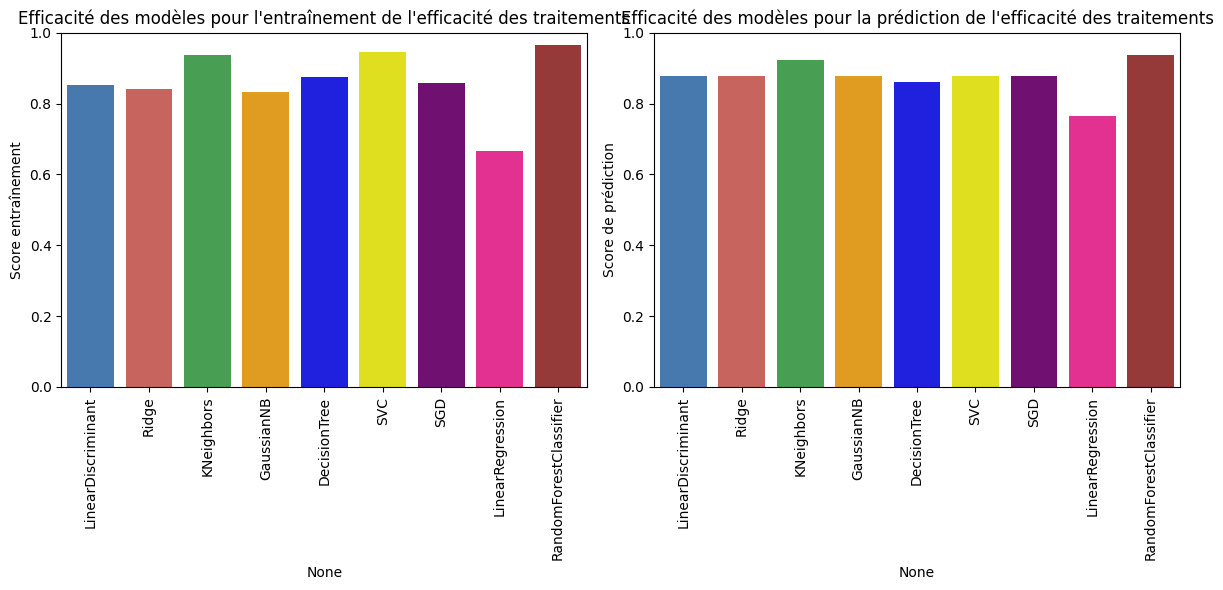

In [123]:
List_of_models = [LinearDiscriminantAnalysis(solver = 'svd', store_covariance = True, tol = 0.0001),
                  RidgeClassifier(alpha = 1, copy_X = True, fit_intercept = True, solver = 'auto', tol = 0.0001),
                  KNeighborsClassifier(algorithm = 'auto', metric = 'minkowski', p = 1),
                  GaussianNB(var_smoothing = 0.8111308307896871),
                  DecisionTreeClassifier(criterion = 'gini', max_depth = 20, min_samples_leaf = 1, min_samples_split = 0.1, splitter = 'random'),
                  SVC(gamma = 1, kernel = 'poly', probability = True),
                  SGDClassifier(alpha = 0.001, fit_intercept = True, l1_ratio = 0.3, loss = 'hinge', penalty = 'elasticnet', tol = 0.0003),
                  LinearRegression(copy_X = True, fit_intercept = True, positive = False),
                  RandomForestClassifier(criterion = 'gini', max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 5, n_estimators = 20)]

List_of_models_for_graph = ["LinearDiscriminant", "Ridge", "KNeighbors", "GaussianNB", "DecisionTree", "SVC", "SGD", "LinearRegression", "RandomForestClassifier"]

df_results = pd.DataFrame(index = ["Score entraînement", "Score de prédiction", "MAE", "RMSE", "median absolute error"], columns = ["LinearDiscriminant"])

for i in range(len(List_of_models)):
  model_class = List_of_models[i] 
  model_class.fit(X_train, y_train)
  y_pred = model_class.predict(X_test)
  results_classification = np.array([model_class.score(X_train,y_train), model_class.score(X_test,y_test), mean_absolute_error(y_test,y_pred), np.sqrt(mean_squared_error(y_test,y_pred)), median_absolute_error(y_test,y_pred)])
  df_results[List_of_models_for_graph[i]] = results_classification

  df_graph = df_results.transpose()
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
ax1 = sns.barplot(x=df_graph.index, y=df_graph["Score entraînement"].values, data=df_graph, ax=axs[0], palette = custom_palette)
ax2 = sns.barplot(x=df_graph.index, y=df_graph["Score de prédiction"].values, data=df_graph, palette = custom_palette)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax1.set_title('Efficacité des modèles pour l\'entraînement de l\'efficacité des traitements')
ax1.set_ylabel('Score entraînement')
ax1.set(ylim=(0, 1))
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)
ax2.set_title('Efficacité des modèles pour la prédiction de l\'efficacité des traitements')
ax2.set_ylabel('Score de prédiction')
ax2.set(ylim=(0, 1))

plt.tight_layout()

In [124]:
model_rf = RandomForestClassifier(criterion = 'gini', max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 5, n_estimators = 20)
model_rf.fit(X_train, y_train)

joblib.dump(model_rf, 'model_rf.joblib')

['model_rf.joblib']

In [125]:
model_rf = load('model_rf.joblib')

In [126]:
def to_labels_multiclass(probs, thresholds):
    """
    Convertit les probabilités en labels pour 3 classes en utilisant des seuils
    """
    n_samples = probs.shape[0]
    labels = np.zeros(n_samples, dtype='int')
    for i in range(n_samples):
        # Compare chaque probabilité avec son seuil correspondant
        valid_classes = [j for j in range(3) if probs[i, j] >= thresholds[j]]
        if len(valid_classes) == 0:
            # Si aucune classe ne dépasse son seuil, prendre la plus probable
            labels[i] = np.argmax(probs[i])
        else:
            # Sinon prendre la classe avec la plus haute probabilité parmi celles dépassant leur seuil
            labels[i] = valid_classes[np.argmax([probs[i, j] for j in valid_classes])]
    return labels

In [127]:
def evaluate_thresholds(y_true, y_probs, threshold_range=np.arange(0, 1, 0.1)):
    """
    Évalue différentes combinaisons de seuils pour les 3 classes
    """
    best_score = 0
    best_thresholds = [0.5, 0.5, 0.5]
    # Teste différentes combinaisons de seuils
    for t1 in threshold_range:
        for t2 in threshold_range:
            for t3 in threshold_range:
                thresholds = [t1, t2, t3]
                y_pred = to_labels_multiclass(y_probs, thresholds)
                score = f1_score(y_true, y_pred, average='macro')
                if score > best_score:
                    best_score = score
                    best_thresholds = thresholds
    return best_thresholds, best_score

In [128]:
def plot_multiclass_roc(y_true, y_probs, class_names=None):
    """
    Trace les courbes ROC pour chaque classe (one-vs-rest)
    """
    if class_names is None:
        class_names = [f'Class {i}' for i in range(3)]
    plt.figure(figsize=(10, 8))
    # Calcule et trace la courbe ROC pour chaque classe
    auc_scores = []
    for i in range(3):
        # Prépare les labels binaires (one-vs-rest)
        y_binary = (y_true == i).astype(int)
        # Calcule la courbe ROC
        fpr, tpr, thresholds = roc_curve(y_binary, y_probs[:, i])
        auc = roc_auc_score(y_binary, y_probs[:, i])
        auc_scores.append(auc)
        # Trace la courbe
        plt.plot(fpr, tpr, marker='.', label=f'{class_names[i]} (AUC={auc:.3f})')
    # Ajoute la ligne de référence
    plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Multi-class Classification')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    return auc_scores

In [129]:
def plot_confusion_matrix(y_true, y_pred, class_names=None):
    if class_names is None:
        class_names = [f'Class {i}' for i in range(3)]
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
       
    plt.title('Matrice de Confusion')
    plt.xlabel('Prédiction')
    plt.ylabel('Réalité')
    plt.tight_layout()

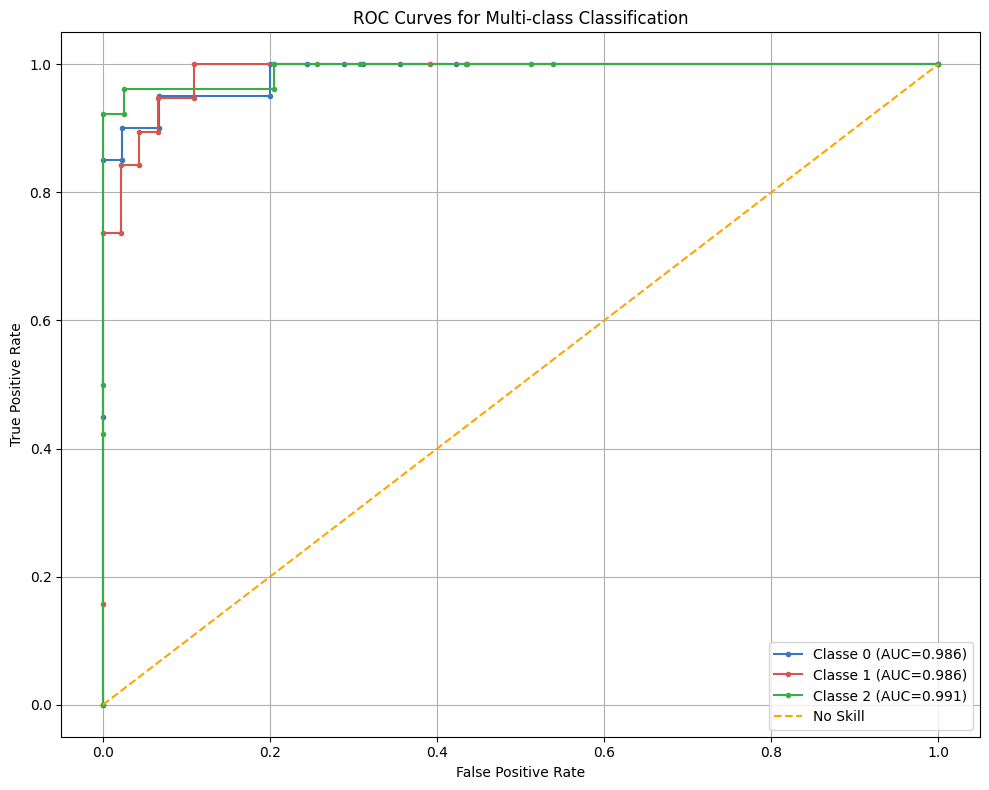

In [132]:
yhat_prob = model_rf.predict_proba(X_test)
 
# Trouver les meilleurs seuils
best_thresholds, best_score = evaluate_thresholds(y_test, yhat_prob)
#print(f'Meilleurs seuils: {best_thresholds}')
#print(f'F1-Score: {best_score}')
 
# Tracer les courbes ROC
y_pred = to_labels_multiclass(yhat_prob, best_thresholds)
auc_scores = plot_multiclass_roc(y_test, yhat_prob, ['Classe 0', 'Classe 1', 'Classe 2'])

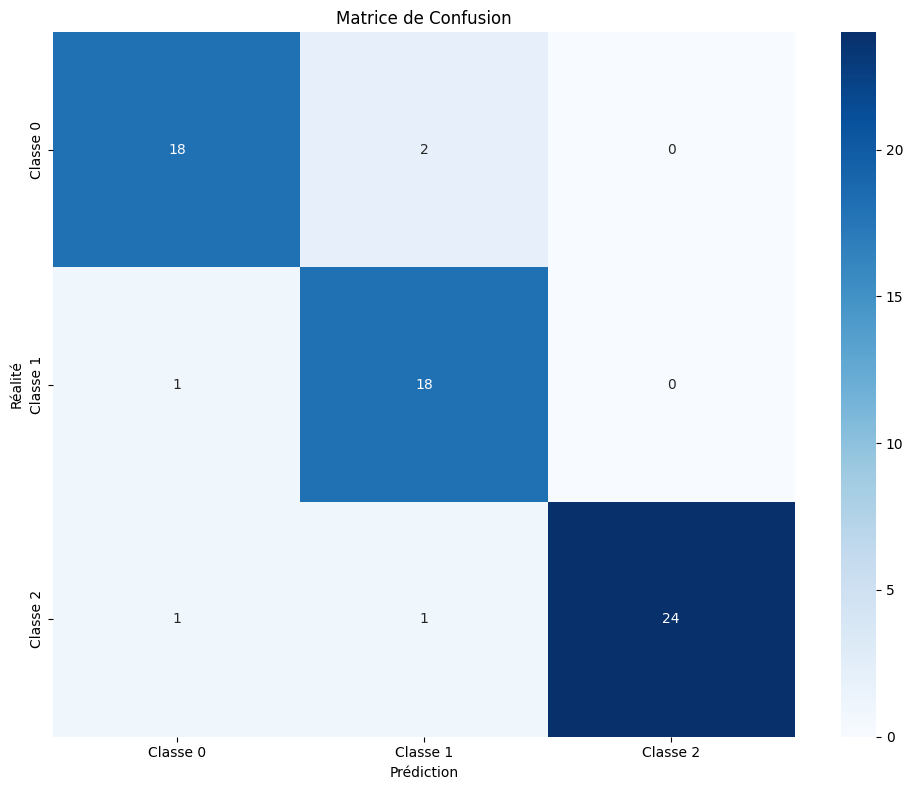

In [131]:
plot_confusion_matrix(y_test, y_pred, ['Classe 0', 'Classe 1', 'Classe 2'])
 
plt.show()